<a href="https://colab.research.google.com/github/practice-grounds-wpaarth24/Dog_Breed_Classification/blob/master/Dog_Breed_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
zip_ref = zipfile.ZipFile("Dataset.zip")
zip_ref.extractall()
zip_ref.close()

In [2]:
import os
import pathlib
import numpy as np

data_dir = pathlib.Path("/content/Dataset/Train")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['German Sheperd' 'Golden Retriever' 'Poodle']


In [3]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def view_random_image(target_dir, classes):
  target_folder = pathlib.Path(target_dir)
  fig, axes = plt.subplots(1, len(classes), figsize=(15, 15))
  for i, cls in enumerate(classes):
    folder = target_folder / cls
    img_path = folder / random.choice(os.listdir(folder))
    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis(False)
  plt.show()


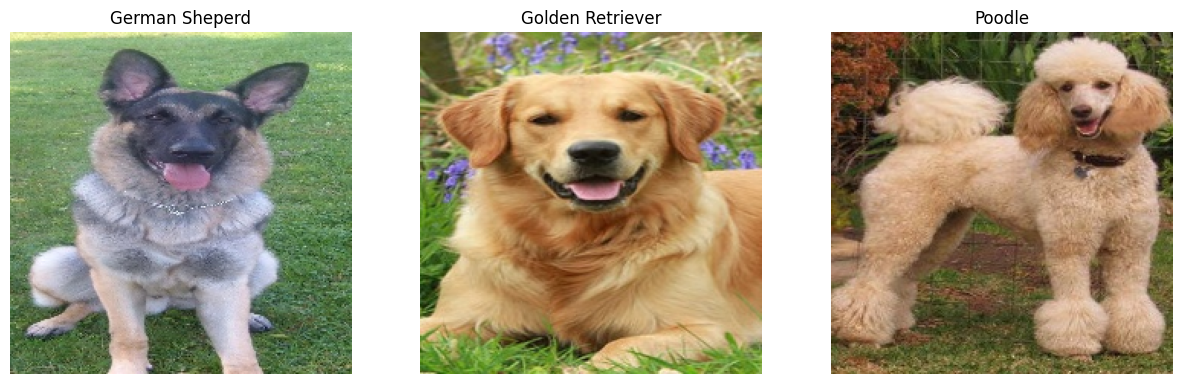

In [4]:
view_random_image("/content/Dataset/Train", class_names)

In [28]:
import numpy as np
def simulate_mixed_labels(pure_label, num_classes, mix_prob=0.2):
    pure_label = pure_label.numpy()  # Convert Tensor to NumPy
    if np.random.rand() < mix_prob:
        second_breed = np.random.randint(0, num_classes)

        while second_breed == np.argmax(pure_label):
            second_breed = np.random.randint(0, num_classes)

        alpha = np.random.uniform(0.4, 0.6)
        mixed_label = np.zeros_like(pure_label)
        mixed_label[np.argmax(pure_label)] = alpha
        mixed_label[second_breed] = 1 - alpha

        return mixed_label.astype(np.float32)
    else:
        return pure_label.astype(np.float32)


In [36]:
def augment_labels(images, labels):
    # Ensure labels have shape (batch_size, num_classes)
    # labels = tf.squeeze(labels, axis=-1)  # Remove the extra dimension - This line is causing the error!
    # No need to squeeze as labels are already in shape (batch_size, num_classes)
    # labels are already one-hot encoded by ImageDataGenerator with class_mode='categorical'
    # tf.print(tf.shape(labels))  # Uncomment this line for debugging to print the shape of labels
    return images, labels

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [38]:
train_dir = "/content/Dataset/Train"
test_dir = "/content/Dataset/Valid"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (224,224),
                                               batch_size=25,
                                               class_mode ='categorical'
                                               )
test_data = test_datagen.flow_from_directory(test_dir,
                                               target_size = (224,224),
                                               batch_size=25,
                                               class_mode ='categorical'
                                               )

Found 353 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


In [39]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_data,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32)  # Changed output signature to (None, 3)
    )
).map(augment_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [40]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/1",
                   trainable=False)

hub_layer_wrapper = tf.keras.layers.Lambda(lambda x: hub_layer(x))

m = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    hub_layer_wrapper,
    tf.keras.layers.Dense(3, activation='softmax')
])

The following Variables were used a Lambda layer's call (lambda_4), but
are not present in its tracked objects:
  <tf.Variable 'resnet_v2_50/block3/unit_1/bottleneck_v2/conv2/weights:0' shape=(3, 3, 256, 256) dtype=float32>
  <tf.Variable 'resnet_v2_50/block2/unit_2/bottleneck_v2/conv2/BatchNorm/gamma:0' shape=(128,) dtype=float32>
  <tf.Variable 'resnet_v2_50/block1/unit_3/bottleneck_v2/conv2/BatchNorm/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'resnet_v2_50/block3/unit_6/bottleneck_v2/conv2/weights:0' shape=(3, 3, 256, 256) dtype=float32>
  <tf.Variable 'resnet_v2_50/block3/unit_1/bottleneck_v2/shortcut/weights:0' shape=(1, 1, 512, 1024) dtype=float32>
  <tf.Variable 'resnet_v2_50/block2/unit_2/bottleneck_v2/conv2/weights:0' shape=(3, 3, 128, 128) dtype=float32>
  <tf.Variable 'resnet_v2_50/block4/unit_3/bottleneck_v2/conv2/BatchNorm/beta:0' shape=(512,) dtype=float32>
  <tf.Variable 'resnet_v2_50/block4/unit_1/bottleneck_v2/preact/beta:0' shape=(1024,) dtype=float32>
  <tf.V

In [41]:
m.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
history = m.fit(train_dataset,
                epochs=10,
                validation_data=test_data,
                )


Epoch 1/10
   1333/Unknown - 444s 327ms/step - loss: 0.0044 - accuracy: 0.9989

In [18]:
def precprocess_image(filename):
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img)
  img = tf.image.resize(img, (224, 224))
  img = img/255.
  return img

In [19]:
import urllib.request
url = "https://preview.redd.it/bxjntfqmel661.jpg?width=640&crop=smart&auto=webp&s=6b406cdbe4a0547f45afb525252b7f801ce06189"
filename = "image.jpg"
urllib.request.urlretrieve(url, filename)

('image.jpg', <http.client.HTTPMessage at 0x7cb3c2a39b70>)

In [33]:
def prediction(filename):
    img = precprocess_image(filename)
    img = tf.expand_dims(img, axis=0)
    pred = m.predict(img)
    plt.figure(figsize=(5,5))
    plt.imshow(mpimg.imread(filename))
    plt.title(class_names[np.argmax(pred)])
    plt.axis("off")
    plt.show()

1/1 [==============================] - 0s 73ms/step


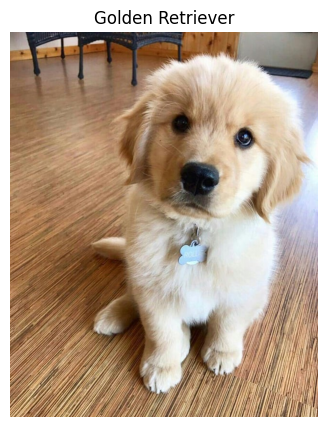

In [36]:
prediction("image.jpg")